In [1]:
# https://github.com/MhLiao/DB
# https://github.com/zonasw/DBNet
# https://github.com/WenmuZhou/DBNet.pytorch
# https://github.com/xuannianz/DifferentiableBinarization
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device_name = tf.test.gpu_device_name()
    print('Found GPU at:', device_name)
    !nvcc -V
else: print('Using CPU')

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Hyperparameters

In [2]:
IGNORE_TEXTS = ['###']
IMAGE_SIZE = 960
THRESH_MIN = 0.3
THRESH_MAX = 0.7
SHRINK_RATIO = 0.4

MIN_BOX_SCORE = 0.6
MAX_CANDIDATES = 50
IMAGE_SHORT_SIDE = 736
AREA_PRECISION_CONSTRAINT = 0.4
AREA_RECALL_CONSTRAINT = 0.4

In [3]:
TRAIN_PATHS_MAP = './Train.txt'
VALIDATE_PATHS_MAP = './Validate.txt'
TRAIN_BATCH_SIZE = 4
VALIDATE_BATCH_SIZE = 1
EPOCHS = 100

# Load the data

In [4]:
from loader import AnnotationsImporter, DBNetGenerator
train_annotations = AnnotationsImporter(TRAIN_PATHS_MAP)
validate_annotations = AnnotationsImporter(VALIDATE_PATHS_MAP)

[GET] Loading from ./Train.txt: 2359 images
[GET] Loading from ./Validate.txt: 594 images


In [5]:
print(
    f'Number of images found:'
    f' {train_annotations.images_count} + {validate_annotations.images_count} ='
    f' {train_annotations.images_count + validate_annotations.images_count}\n'
    f'Number of bounding boxes in all images:'
    f' {train_annotations.all_boxes_count} + {validate_annotations.all_boxes_count} ='
    f' {train_annotations.all_boxes_count + validate_annotations.all_boxes_count}'
)

Number of images found: 2359 + 594 = 2953
Number of bounding boxes in all images: 30710 + 7903 = 38613


In [6]:
train_generator = DBNetGenerator(
    train_annotations.annotations, 
    TRAIN_BATCH_SIZE, IMAGE_SIZE, IGNORE_TEXTS,  
    THRESH_MIN, THRESH_MAX, SHRINK_RATIO, seed=2022
)
validate_generator = DBNetGenerator(
    validate_annotations.annotations, 
    VALIDATE_BATCH_SIZE, IMAGE_SIZE, IGNORE_TEXTS, 
    THRESH_MIN, THRESH_MAX, SHRINK_RATIO, seed=None # No shuffle
)

# Build and compile the model

In [7]:
from models import DBNet
from processor import PostProcessor
post_processor = PostProcessor(min_box_score=MIN_BOX_SCORE, max_candidates=MAX_CANDIDATES)
dbnet = DBNet(post_processor, backbone='ResNet18', k=50)

In [8]:
from tensorflow.keras.optimizers import Adadelta
from losses import DBLoss

# Adadelta tends to benefit from higher initial learning rate values compared to
# other optimizers. Here use 1.0 to match the exact form in the original paper
dbnet.compile(optimizer=Adadelta(learning_rate=1.0), loss=DBLoss())
dbnet.model.summary(line_length=120)

Model: "DBNet"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, None, None, 3)]    0             []                                      
                                                                                                                        
 conv1 (Conv2D)                        (None, None, None, 64)     9408          ['image[0][0]']                         
                                                                                                                        
 bn_conv1 (BatchNormalization)         (None, None, None, 64)     256           ['conv1[0][0]']                         
                                                                                                                        
 conv1_relu (Acti

                                                                                                                        
 bn3a_branch2b (BatchNormalization)    (None, None, None, 128)    512           ['res3a_branch2b[0][0]']                
                                                                                                                        
 bn3a_branch1 (BatchNormalization)     (None, None, None, 128)    512           ['res3a_branch1[0][0]']                 
                                                                                                                        
 res3a (Add)                           (None, None, None, 128)    0             ['bn3a_branch2b[0][0]',                 
                                                                                 'bn3a_branch1[0][0]']                  
                                                                                                                        
 res3a_relu (Activation)        

                                                                                                                        
 res4b1_relu (Activation)              (None, None, None, 256)    0             ['res4b1[0][0]']                        
                                                                                                                        
 padding5a_branch2a (ZeroPadding2D)    (None, None, None, 256)    0             ['res4b1_relu[0][0]']                   
                                                                                                                        
 res5a_branch2a (Conv2D)               (None, None, None, 512)    1179648       ['padding5a_branch2a[0][0]']            
                                                                                                                        
 bn5a_branch2a (BatchNormalization)    (None, None, None, 512)    2048          ['res5a_branch2a[0][0]']                
                                

 P2 (ConvBnRelu)                       (None, None, None, 64)     147776        ['tf.__operators__.add_2[0][0]']        
                                                                                                                        
 P3 (Sequential)                       (None, None, None, 64)     147776        ['tf.__operators__.add_1[0][0]']        
                                                                                                                        
 P4 (Sequential)                       (None, None, None, 64)     147776        ['tf.__operators__.add[0][0]']          
                                                                                                                        
 P5 (Sequential)                       (None, None, None, 64)     147776        ['in5[0][0]']                           
                                                                                                                        
 fuse (Concatenate)             

# Callbacks

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from metrics import TedEvalMetric
from tqdm.notebook import tqdm

# Stop if no improvement after 5 epochs
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

# Calculate TedEvalMetric after 5 epochs
tedeval_callback = TedEvalMetric(
    true_annotations = validate_annotations.annotations, 
    ignore_texts = IGNORE_TEXTS, 
    min_box_score = MIN_BOX_SCORE,
    image_short_side = IMAGE_SHORT_SIDE,
    area_precision_constraint = AREA_PRECISION_CONSTRAINT,
    area_recall_constraint = AREA_RECALL_CONSTRAINT,
    progressbar = tqdm,
    eval_steps = 5
)

Reading evaluation images:   0%|          | 0/594 [00:00<?, ?image/s]

# Training

In [10]:
%%time
history = dbnet.fit(
    train_generator,
    validation_data = validate_generator,
    validation_steps = len(validate_generator),
    steps_per_epoch = len(train_generator),
    epochs = EPOCHS,
    callbacks = [early_stopping_callback, tedeval_callback],
    verbose = 1
).history
dbnet.model.save_weights('dbnet.h5')

Epoch 1/100
590/590 [==============================] - 319s 525ms/step - loss: 1.9664 - val_loss: 1.8430
Epoch 2/100
590/590 [==============================] - 321s 544ms/step - loss: 1.4173 - val_loss: 1.5732
Epoch 3/100
590/590 [==============================] - 310s 526ms/step - loss: 1.3029 - val_loss: 1.4447
Epoch 4/100
590/590 [==============================] - 324s 549ms/step - loss: 1.2417 - val_loss: 1.4652
Epoch 5/100
590/590 [==============================] - ETA: 0s - loss: 1.2001

Predicting bounding boxes:   0%|          | 0/594 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/594 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.9543 - recall: 0.8425 - hmean: 0.8949
590/590 [==============================] - 382s 648ms/step - loss: 1.1998 - val_loss: 1.5865
Epoch 6/100
590/590 [==============================] - 327s 553ms/step - loss: 1.1626 - val_loss: 1.3637
Epoch 7/100
590/590 [==============================] - 327s 554ms/step - loss: 1.1384 - val_loss: 1.3434
Epoch 8/100
590/590 [==============================] - 323s 548ms/step - loss: 1.1178 - val_loss: 1.5180
Epoch 9/100
590/590 [==============================] - 326s 553ms/step - loss: 1.0914 - val_loss: 1.2552
Epoch 10/100
590/590 [==============================] - ETA: 0s - loss: 1.0710

Predicting bounding boxes:   0%|          | 0/594 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/594 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.9900 - recall: 0.8516 - hmean: 0.9156
590/590 [==============================] - 377s 639ms/step - loss: 1.0709 - val_loss: 1.2341
Epoch 11/100
590/590 [==============================] - 323s 547ms/step - loss: 1.0536 - val_loss: 1.3445
Epoch 12/100
590/590 [==============================] - 323s 547ms/step - loss: 1.0284 - val_loss: 1.5100
Epoch 13/100
590/590 [==============================] - 324s 549ms/step - loss: 1.0083 - val_loss: 1.3002
Epoch 14/100
590/590 [==============================] - 327s 554ms/step - loss: 0.9852 - val_loss: 1.3535
Epoch 15/100
590/590 [==============================] - ETA: 0s - loss: 0.9624

Predicting bounding boxes:   0%|          | 0/594 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/594 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.9925 - recall: 0.8875 - hmean: 0.9371
590/590 [==============================] - 373s 632ms/step - loss: 0.9625 - val_loss: 1.3759
Epoch 16/100
 15/590 [..............................] - ETA: 4:08 - loss: 0.8722

# Inference

In [11]:
import cv2
from utils import resize_image_short_side, draw_predictions
raw_image = cv2.cvtColor(cv2.imread('test.jpg'), cv2.COLOR_BGR2RGB)
image = resize_image_short_side(raw_image, image_short_side=IMAGE_SHORT_SIDE)
image = image.astype(float) / 255.0

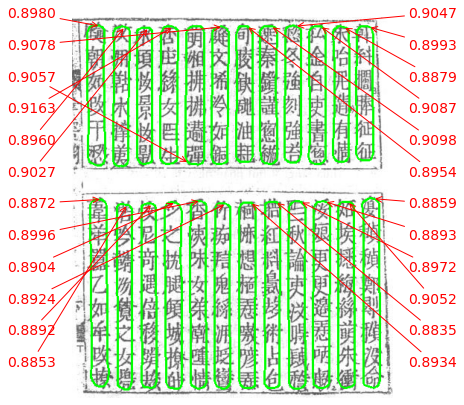

In [12]:
batch_boxes, batch_scores = dbnet.predict(
    batch_images = tf.expand_dims(image, 0), 
    batch_true_sizes = [raw_image.shape[:2]], 
    output_polygon = True
)
draw_predictions(raw_image, batch_boxes[0], batch_scores[0])